In [1]:
import os

In [2]:
#list the current work dir
os.getcwd()

#change the current work dir
os.chdir('/hpc/home/fcw/lute/')

In [54]:
# Import all dependencies
import os
import csv
import numpy as np
import argparse
from functools import partial
from itertools import product

from multiprocessing import Pool
from matplotlib import pyplot as plt
import geopandas as gpd
from scipy.spatial.distance import hamming as hamming_loss
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy
from sklearn.metrics import jaccard_score
import Datasets
import torch

In [63]:
def get_matches(treatment, control, match_radius, distance_metric):
    """This function will return the treatment and control values that are within a certain distance of each other"""
    # Set up the treatment and control values
    treatment_vals = []
    control_vals = []
    match_distance = []  # Record the average match distance

    for t_img, t_img_name, t_temp, match_val in treatment:
        # Create control function and implement as a filter
        get_control_pool = partial(
            filter_control_matches_by_radius, match_radius, match_val
        )
        valid_controls = list(filter(get_control_pool, control))

        if len(valid_controls) == 0:
            continue
        else:
            treatment_vals.append(t_temp)

        # Get the closest control via the distance metric
        control_val, control_dist = get_closest_control(
            valid_controls, t_img, t_img_name, distance_metric
        )
        control_vals.append(control_val)
        match_distance.append(control_dist)
    return treatment_vals, control_vals, match_distance

In [92]:
def weighted_hamming_wrapper(n = 256):
    n = 256
    center = n // 2

    # Create 1D arrays representing the x and y coordinates
    x = np.arange(n)
    y = np.arange(n)
    
    # Use meshgrid to create 2D arrays representing the x and y distances from the center
    x_distance, y_distance = np.meshgrid(x - center, y - center, indexing='ij')

    # Use linalg.norm to create a 2D array representing the Euclidean distances from the center
    distance = np.linalg.norm(np.stack((x_distance, y_distance), axis=-1), axis=-1)

    # Calculate the weight of each pixel using the formula 1 / (1 + distance**2)
    weight_matrix = 1 / (1 + distance**2)

    # Stack the weight matrix along the third axis to create a 256 x 256 x 4 array
    stacked_weights = np.stack([weight_matrix] * 4, axis=-1)
    
    return hamming_loss(x, y, w=stacked_weights.flatten())

In [107]:
def jensenshannon_wrapper(x, y):
#     land_use_1 = x.reshape(4, 256, 256)
#     land_use_2 = y.reshape(4, 256, 256)
    
#     # Compute the probability distributions by dividing each pixel value by the total number of pixels
#     dist1 = land_use_1 / land_use_1.sum(axis=(0, 1, 2), keepdims=True)
#     dist2 = land_use_2 / land_use_2.sum(axis=(0, 1, 2), keepdims=True)

#     # Flatten the distributions to 1D arrays for use with the JSD metric
#     flat_dist1 = dist1.reshape(-1)
#     flat_dist2 = dist2.reshape(-1)

    x = x.reshape(4, 256, 256)
    y = y.reshape(4, 256, 256)

    # Convert one-hot encoded vectors to probability distributions
    x_probs = np.apply_along_axis(lambda a: np.exp(a) / np.sum(np.exp(a)), axis=2, arr=x)
    y_probs = np.apply_along_axis(lambda a: np.exp(a) / np.sum(np.exp(a)), axis=2, arr=y)
    
    return jensenshannon(x_probs.flatten(), y_probs.flatten())

In [108]:
def kl_divergence_wrapper(x,y):
    t_img = x.reshape((256,256,4))
    c_img = y.reshape((256,256,4))

    t_dist = np.mean(t_img, axis=(0, 1))
    c_dist = np.mean(c_img, axis=(0, 1))
    
    return entropy(t_dist, c_dist)

In [109]:
def jaccard_distance_wrapper(x,y):
    #Code is exactly the same as sklearn, can choose whatever is fastest
    #distance_metric = lambda x, y: 1 - (np.sum(np.logical_and(x, y)) / np.sum(np.logical_or(x, y)))
    
    return 1 - jaccard_score(x, y)

In [110]:
def get_closest_control(control_pool, t_img, t_img_name, distance_metric):
    """This function will calculate the closest control based on the distance used."""
    best_dist = np.inf
    best_control = None

    # TODO -- add more distance metrics here
    if distance_metric == "hamming":
        distance_metric = hamming_loss
    elif distance_metric == "jaccard":
        distance_metric = jaccard_distance_wrapper
    elif distance_metric == "weighted_hamming":
        distance_metric = weighted_hamming_wrapper
    elif distance_metric == "kl_divergence":
        distance_metric = kl_divergence_wrapper
    elif distance_metric == "jensenshannon":
        distance_metric = jensenshannon_wrapper
    else:
        raise ValueError(f"Distance metric {distance_metric} not recognized.")

    for c_img, c_img_name, c_temp, _ in control_pool:
        sim = distance_metric(t_img.flatten(), c_img.flatten())

        if sim < best_dist:
            best_dist = sim
            best_control = c_temp
            best_c_img_name = c_img_name
    
    print(best_c_img_name, t_img_name, best_dist)

    return best_control, best_dist

In [111]:
def filter_control_matches_by_radius(radius, treatment_val, control_val):
    """This is a function that will return true if the treatment and control
    are within a certain distance of each other"""
    if abs(treatment_val - control_val[3]) < radius:
        return True
    return False

In [112]:
def create_treatment_and_control_groups(
    dist,
    treatment_idx,
    control_idx,
    treatment_pctg,
    control_pctg,
    match_values,
    dataset,
):
    treatment_group = []
    control_group = []

    # Set a few variables
    w, h, _ = dataset[0][0].shape

    # Look at each image and file into the categories
    for (img, file_name, label), mv in zip(dataset, match_values):
        # Look at pixels in the middle of the image
        area = img[w // 2 - dist : w // 2 + dist, h // 2 - dist : h // 2 + dist, :]

        if area[:, :, treatment_idx].mean() > treatment_pctg:
            treatment_group.append((img, file_name, label, mv))

        if area[:, :, control_idx].mean() > control_pctg:
            control_group.append((img, file_name, label, mv))

    return treatment_group, control_group

In [113]:
def calc_match_values(dataset, df, n_min_dist, nn):
    match_values = []

    # Iterate over the dataset to calculate the match values
    for i, (_, file_name, _) in enumerate(dataset):
        # Read off the point from the file name
        point_id = int(file_name.split("_")[-1].split(".")[0])

        # Get the point
        point = df.iloc[point_id]

        # Calculate the distance close to that point id
        df["dist"] = np.sqrt(
            (df.geometry.x - point.geometry.x) ** 2
            + (df.geometry.y - point.geometry.y) ** 2
        )

        # Calculate the prog score
        sort_arr = df[
            df["dist"] > n_min_dist
        ]  # Must be at least 600 meters away (to be far enough away from the point)
        prog_score = sort_arr.sort_values("dist")[0:nn]["temp_f"].mean()

        # Append value
        match_values.append(prog_score)

    return np.array(match_values)

In [114]:
def load_traversal_path(data_path):
    """Read the file and convert to mercator projection"""
    df = gpd.read_file(data_path)
    # Convert to meters
    return df.to_crs(epsg=3857)

In [115]:
# # Set up arguments to be passed via script
# parser = argparse.ArgumentParser(description="Calculate ATE")

# # Argument for where to load data
# parser.add_argument(
#     "--traversal_data",
#     type=str,
#     default="/datacommons/carlsonlab/zdc6/uhi/data/traverses/pm_trav.shp",
# )
# # Argument for where to dump results
# parser.add_argument("--results_path", type=str, default="./ate_results.csv")
# # Argument for distance metric
# parser.add_argument("--distance_metric", type=str, default="hamming")

# parser.add_argument("--neighborhood_min_dist", type=int, default=550)

args = {
    "neighborhood_min_dist": 550,
    "distance_metric": "jensenshannon",
    "results_path": "./ate_results.csv",
    "traversal_data": "/datacommons/carlsonlab/zdc6/uhi/data/traverses/pm_trav.shp"
}

class DotDict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

args = DotDict(args)

In [116]:
# Load images
dataset = Datasets.load("pm_train_only")
# Load traversal path
df = load_traversal_path(args.traversal_data)
print("Loaded data")

Loaded data


In [117]:
##################
#  Set up parameters to checkout
##################

# This is the minimum distance from which to retrieve
# the nearest neighbors. We do not want to get
# neighbors that are closer to a specific distance, as
# these neighbors are more directly influenced by
# the covariates.
neighborhood_min_dist = [args.neighborhood_min_dist]

# Number of neighbors to average over.
num_neighbors = [10]

# Treatment/control values
distance = [40]  # box of 2*distance x 2*distance in the center
treatment_idx = 0  # id used for concrete (this should not change)
control_idx = 2  # id used for trees (this should not change)
treatment_pctg = [0.7]  # percentage covered by treatment
control_pctg = [0.7]  # percentage covered by control
match_radius = [1]

# Get the total number of trials to run:
num_trials = (
    len(neighborhood_min_dist)
    * len(num_neighbors)
    * len(distance)
    * len(treatment_pctg)
    * len(control_pctg)
    * len(match_radius)
)
print(f"Total number of trials: {num_trials}")
counter = 1

Total number of trials: 1


In [118]:
# Create to store results
with open(args.results_path, "w", newline="") as f:
    writer = csv.writer(f, delimiter=",")

    # Write the header
    writer.writerow(
        [
            "Neighborhood min dist",
            "Num neighbors",
            "Treatment/Control Radius",
            "Treatment %",
            "Control %",
            "Match Radius",
            "Treatment Count",
            "Control Count",
            "ATE",
            "TE Std",
            "Average Match Distance",
        ]
    )

In [119]:
# Iterate over the prognostic dependent variables
for n_min_dist, nn in product(neighborhood_min_dist, num_neighbors):
    print(f"Neighborhood min dist: {n_min_dist}, Num neighbors: {nn}")
    # Calculate the match values
    match_values = calc_match_values(dataset, df, n_min_dist, nn)
    for dist, t_pctg, c_pctg, match_rad in product(
        distance, treatment_pctg, control_pctg, match_radius
    ):
        # Get the treatment and controls
        print(f"Dist: {dist}, Treatment %: {t_pctg}, Control %: {c_pctg}")
        print(f"Running trial {counter} of {num_trials}")
        treatment, control = create_treatment_and_control_groups(
            dist,
            treatment_idx,
            control_idx,
            t_pctg,
            c_pctg,
            match_values,
            dataset,
        )

        print("\tPre-matching treatment size: ", len(treatment))
        print("\tPre-matching control size: ", len(control))

        treatment_vals, control_vals, match_distances = get_matches(
            treatment, control, match_rad, args.distance_metric
        )

        ate = np.mean(treatment_vals) - np.mean(control_vals)
        ate_std = np.std(np.array(treatment_vals) - np.array(control_vals))
        # Record the results
        with open(args.results_path, "a", newline="") as f:
            writer = csv.writer(f, delimiter=",")
            writer.writerow(
                [
                    n_min_dist,
                    nn,
                    dist,
                    t_pctg,
                    c_pctg,
                    match_rad,
                    len(treatment_vals),
                    len(control_vals),
                    ate,
                    ate_std,
                    np.mean(match_distances),
                ]
            )
            print([
                    n_min_dist,
                    nn,
                    dist,
                    t_pctg,
                    c_pctg,
                    match_rad,
                    len(treatment_vals),
                    len(control_vals),
                    ate,
                    ate_std,
                    np.mean(match_distances),
                ])
        print(f"\tATE: {ate}")
        counter += 1

Neighborhood min dist: 550, Num neighbors: 10
Dist: 40, Treatment %: 0.7, Control %: 0.7
Running trial 1 of 1
	Pre-matching treatment size:  8
	Pre-matching control size:  158
planet_5_NCpoint_16211.pt planet_1_NCpoint_8930.pt 0.1977504599771094
planet_5_NCpoint_16463.pt planet_5_NCpoint_32063.pt 0.20444499188188028
planet_1_NCpoint_9098.pt planet_5_NCpoint_32945.pt 0.19942170231423853
planet_5_NCpoint_21097.pt planet_0_NCpoint_24835.pt 0.21029211875659118
planet_5_NCpoint_30782.pt planet_0_NCpoint_24772.pt 0.20811373947245845
planet_5_NCpoint_25528.pt planet_0_NCpoint_24793.pt 0.2085707641719465
planet_5_NCpoint_21097.pt planet_0_NCpoint_24814.pt 0.21638835614230909
planet_5_NCpoint_11791.pt planet_5_NCpoint_24184.pt 0.21658666069415494
[550, 10, 40, 0.7, 0.7, 1, 8, 8, 2.7012500000000017, 0.9799928252288753, 0.20769609917633605]
	ATE: 2.7012500000000017


In [106]:
#Hamming
#planet_5_NCpoint_16211.pt planet_1_NCpoint_8930.pt 0.27103424072265625
#planet_5_NCpoint_16463.pt planet_5_NCpoint_32063.pt 0.28969573974609375

In [ ]:
#Jaccard
#planet_1_NCpoint_9098.pt planet_5_NCpoint_32945.pt 0.7107333962858042

In [ ]:
#Weighed Hamming
#planet_5_NCpoint_25654.pt planet_5_NCpoint_32063.pt 0.18155833358143086
#planet_5_NCpoint_25654.pt planet_5_NCpoint_32945.pt 0.19104648678327332

In [ ]:
#KL Divergence
#planet_5_NCpoint_11791.pt planet_5_NCpoint_32945.pt 0.007160265796297374

In [ ]:
#Jensenshannon
#planet_5_NCpoint_16211.pt planet_1_NCpoint_8930.pt 0.1977504599771094 (same as Hamming)
#planet_1_NCpoint_9098.pt planet_5_NCpoint_32945.pt 0.19942170231423853 (same as Jaccard)

In [87]:
# planet_4_NCpoint_945.pt planet_1_NCpoint_8489.pt 0.2482757568359375
c_fname = "planet_5_NCpoint_11791"
t_fname = "planet_5_NCpoint_32945"

In [88]:
c_img = plt.imread(f"/datacommons/carlsonlab/fcw/planet_preprocessed_multitask/train/images/{c_fname}.TIF")
t_img = plt.imread(f"/datacommons/carlsonlab/fcw/planet_preprocessed_multitask/train/images/{t_fname}.TIF")

In [89]:
c_img_one_hot = torch.load(f'/datacommons/carlsonlab/zdc6/cs590/land_use/train/img/{c_fname}.pt')
t_img_one_hot = torch.load(f'/datacommons/carlsonlab/zdc6/cs590/land_use/train/img/{t_fname}.pt')

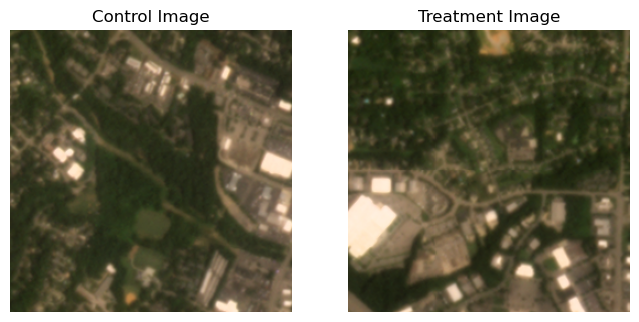

In [90]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,8))

axs[0].imshow(c_img)
axs[1].imshow(t_img)
axs[0].set_title('Control Image')
axs[1].set_title('Treatment Image')

for ax in axs.flat:
    ax.set_axis_off()

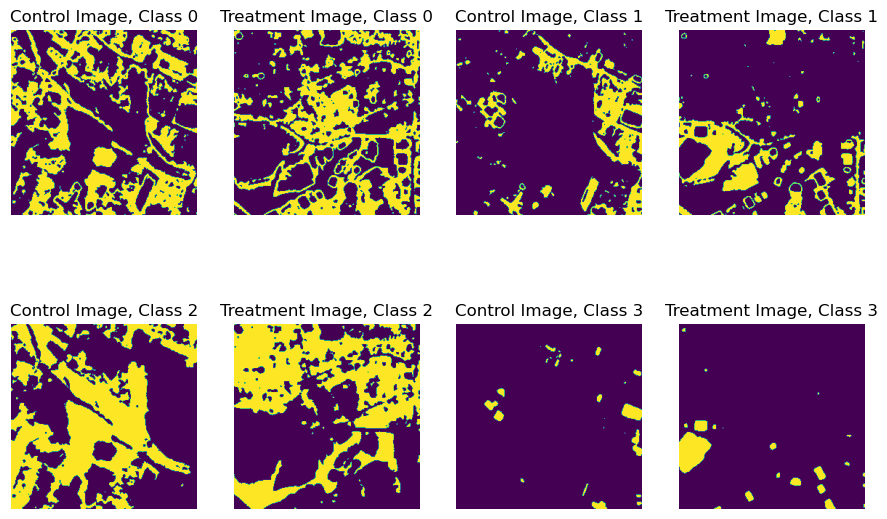

In [91]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(11,7))

axs[0,0].imshow(c_img_one_hot[:,:,0] * 255)
axs[0,1].imshow(t_img_one_hot[:,:,0] * 255)
axs[0, 0].set_title('Control Image, Class 0')
axs[0, 1].set_title('Treatment Image, Class 0')

axs[0,2].imshow(c_img_one_hot[:,:,1] * 255)
axs[0,3].imshow(t_img_one_hot[:,:,1] * 255)
axs[0,2].set_title('Control Image, Class 1')
axs[0,3].set_title('Treatment Image, Class 1')

axs[1,0].imshow(c_img_one_hot[:,:,2] * 255)
axs[1,1].imshow(t_img_one_hot[:,:,2] * 255)
axs[1,0].set_title('Control Image, Class 2')
axs[1,1].set_title('Treatment Image, Class 2')

axs[1,2].imshow(c_img_one_hot[:,:,3] * 255)
axs[1,3].imshow(t_img_one_hot[:,:,3] * 255)
axs[1,2].set_title('Control Image, Class 3')
axs[1,3].set_title('Treatment Image, Class 3')

for ax in axs.flat:
    ax.set_axis_off()